# Imports

In [1]:
import os
import numpy as np
from utils import utils
from utils import plotting
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from keras import optimizers
# Optimizers are Classes or methods used to change the attributes of your machine/deep learning model such as weights and learning rate in order to reduce the losses. Optimizers help to get results faster
# from keras.utils import to_categorical
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import matplotlib.pyplot as plt

# Output Class Setup

In [2]:
# encodings for labels in dataset
classes = ['squats', 'lunges', 'bicep_curls', 'situps', 
        'pushups', 'tricep_extensions', 'dumbbell_rows', 
        'jumping_jacks', 'dumbbell_shoulder_press', 
        'lateral_shoulder_raises']
d={}
for i,ex in enumerate(classes):
    d[ex] = i
d

{'squats': 0,
 'lunges': 1,
 'bicep_curls': 2,
 'situps': 3,
 'pushups': 4,
 'tricep_extensions': 5,
 'dumbbell_rows': 6,
 'jumping_jacks': 7,
 'dumbbell_shoulder_press': 8,
 'lateral_shoulder_raises': 9}

# Data Prep

In [3]:
def prepare_dataset(files, data_path):
    """
    Prepare the dataset using the files provided
    """
    #tqdm functions that wrap around the specified iterable to give a smart progress bar as an output.
    from tqdm import tqdm

    df = pd.DataFrame()
    
    # [2D Pose Estimate	(2 x N x 19)(Frame, Joint 1, Joint 2, ..., Joint 18)]Convert (2, 63918, 19) data to (63918, 2, 19) to (63918, 38) for simplicity
    for w_id in tqdm(files):
        data_dir = os.path.join(data_path, w_id)
        t = utils.load_modality(os.path.join(data_dir, w_id + '_pose_2d.npy'))
        t2_frame = t.transpose(1,0,2).reshape(-1,38)

        
        # Creating nparray for ylabels with each frame
        y = []
        labels = utils.load_labels(os.path.join(data_dir, w_id + '_labels.csv'))
        for label in tqdm(labels):
            f1, f2, rep, lbl = label
            for frame in range(f1, f2+1):
                y.append([frame, d[lbl]])
        y = np.array(y)
        y_df = pd.DataFrame(y)

        # Frame appears twice. Once at the beginning (index 0) and once at pos 19. We don't need the second one.
        t2_df=pd.DataFrame(t2_frame).drop(19, axis=1)
        
        # Removing noise from data 
        # We will only retain the rows in the dataframe for which we have labels available.
        # Achieved with inner join
        df = pd.concat([df,t2_df.merge(y_df, how='inner', on=0)])
    return df

## Building test/train files

In [4]:
train_files = ['01', '02', '03', '04', '06', '07', '08', '16', 
               '17', '18', '14', '15', '19', '20', '12', '13']
train_file_names = list(map(lambda x : 'w' + x, train_files))
test_files = ['05', '09', '10', '11']
test_file_names = list(map(lambda x : 'w' + x, test_files))
val_files = ['00']
val_file_names = list(map(lambda x : 'w' + x, val_files))
data_path = 'data/mm-fit/'

train_df = prepare_dataset(train_file_names, data_path)
test_df = prepare_dataset(test_file_names, data_path)
val_df = prepare_dataset(val_file_names, data_path)
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

(285377, 38)
(73833, 38)
(14543, 38)


In [5]:
train_df.head()

,0,1_x,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,1_y
0,2113.0,654.830,645.013,596.084,586.238,645.049,690.085,715.648,729.248,601.922,...,541.224,692.058,398.234,541.270,684.261,141.536,145.412,151.351,153.287,0
1,2114.0,652.972,645.013,596.068,586.238,647.039,690.085,717.521,729.276,601.872,...,541.224,692.069,400.164,541.270,684.265,141.559,145.413,151.414,153.355,0
2,2115.0,652.972,645.013,596.068,586.255,648.867,690.088,723.402,729.290,599.967,...,541.235,692.077,402.130,541.270,684.265,145.465,147.368,157.229,161.073,0
3,2116.0,652.972,645.013,596.068,586.265,648.918,690.088,725.313,729.392,598.040,...,550.976,692.091,413.893,545.177,684.275,147.526,149.386,163.164,164.981,0
4,2117.0,652.972,645.080,596.084,586.278,648.922,690.119,725.313,731.223,594.121,...,554.898,693.971,423.685,552.984,684.284,157.246,159.194,169.011,170.942,0


In [6]:
test_df.head()

,0,1_x,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,1_y
0,2830.0,554.996,556.818,494.154,449.190,478.490,619.509,660.750,633.292,519.641,...,519.693,654.888,396.193,509.893,654.865,151.430,151.433,151.394,153.295,0
1,2831.0,554.996,556.818,494.154,449.190,478.525,617.632,660.750,631.255,519.687,...,519.693,656.775,398.133,509.893,656.840,163.141,163.163,163.141,163.139,0
2,2832.0,554.996,556.886,494.297,449.190,490.223,617.632,660.709,617.672,519.687,...,519.693,656.784,404.078,511.825,658.786,190.483,188.608,192.519,190.508,0
3,2833.0,554.996,556.895,496.123,449.190,490.224,617.632,660.704,617.672,521.608,...,519.693,656.836,404.083,511.826,658.786,190.484,188.609,192.519,190.508,0
4,2834.0,556.809,556.897,496.193,453.055,494.220,617.632,658.763,613.705,521.628,...,519.694,656.838,415.799,513.799,658.786,204.253,204.261,208.187,208.118,0


## Saving train, test, val set

In [7]:
# Saving X data for training and testing 
np.savetxt(
    'data/X_train.txt',
    train_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)
np.savetxt(
    'data/X_test.txt',
    test_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)
np.savetxt(
    'data/X_val.txt',
    val_df.iloc[:,1:-1].values,
    fmt = '%1.3f',
    delimiter = ','
)

In [8]:
# Saving Y data for training and testing
np.savetxt(
    'data/Y_train.txt',
    train_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)
np.savetxt(
    'data/Y_test.txt',
    test_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)
np.savetxt(
    'data/Y_val.txt',
    val_df.iloc[:,-1].values,
    fmt = '%d',
    delimiter = ','
)

## Data Loading Functions

In [9]:
def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    file.close()
    return X_

def load_Y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    return y_

## Estimation functions

In [10]:
def euclidean_dist(a, b):
    # This function calculates the euclidean distance between 2 point in 2-D coordinates
    # if one of two points is (0,0), dist = 0
    # a, b: input array with dimension: m, 2
    # m: number of samples
    # 2: x and y coordinate
    # https://github.com/tringn/2D-Keypoints-based-Pose-Classifier
    try:
        if (a.shape[1] == 2 and a.shape == b.shape):
            # check if element of a and b is (0,0)
            bol_a = (a[:,0] != 0).astype(int)
            bol_b = (b[:,0] != 0).astype(int)
            dist = np.linalg.norm(a-b, axis=1)
            return((dist*bol_a*bol_b).reshape(a.shape[0],1))
    except:
        print("[Error]: Check dimension of input vector")
        return 0

## Normalization

In [11]:
def norm_X(X):
    #https://github.com/tringn/2D-Keypoints-based-Pose-Classifier/blob/master/pose_classifier_inference.ipynb
    num_sample = X.shape[0]
    # Keypoints
    Nose = X[:,0*2:0*2+2]
    Neck = X[:,1*2:1*2+2]
    RShoulder = X[:,2*2:2*2+2]
    RElbow = X[:,3*2:3*2+2]
    RWrist = X[:,4*2:4*2+2]
    LShoulder = X[:,5*2:5*2+2]
    LElbow = X[:,6*2:6*2+2]
    LWrist = X[:,7*2:7*2+2]
    RHip = X[:,8*2:8*2+2]
    RKnee = X[:,9*2:9*2+2]
    RAnkle = X[:,10*2:10*2+2]
    LHip = X[:,11*2:11*2+2]
    LKnee = X[:,12*2:12*2+2]
    LAnkle = X[:,13*2:13*2+2]
    REye = X[:,14*2:14*2+2]
    LEye = X[:,15*2:15*2+2]
    REar = X[:,16*2:16*2+2]
    LEar = X[:,17*2:17*2+2]

    # Length of head
    length_Neck_LEar = euclidean_dist(Neck, LEar)
    length_Neck_REar = euclidean_dist(Neck, REar)
    length_Neck_LEye = euclidean_dist(Neck, LEye)
    length_Neck_REye = euclidean_dist(Neck, REye)
    length_Nose_LEar = euclidean_dist(Nose, LEar)
    length_Nose_REar = euclidean_dist(Nose, REar)
    length_Nose_LEye = euclidean_dist(Nose, LEye)
    length_Nose_REye = euclidean_dist(Nose, REye)
    length_head      = np.maximum.reduce([length_Neck_LEar, length_Neck_REar, length_Neck_LEye, length_Neck_REye, \
                                 length_Nose_LEar, length_Nose_REar, length_Nose_LEye, length_Nose_REye])
    #length_head      = np.sqrt(np.square((LEye[:,0:1]+REye[:,0:1])/2 - Neck[:,0:1]) + np.square((LEye[:,1:2]+REye[:,1:2])/2 - Neck[:,1:2]))

    # Length of torso
    length_Neck_LHip = euclidean_dist(Neck, LHip)
    length_Neck_RHip = euclidean_dist(Neck, RHip)
    length_torso     = np.maximum(length_Neck_LHip, length_Neck_RHip)
    #length_torso     = np.sqrt(np.square(Neck[:,0:1]-(LHip[:,0:1]+RHip[:,0:1])/2) + np.square(Neck[:,1:2]-(LHip[:,1:2]+RHip[:,1:2])/2))

    # Length of right leg
    length_leg_right = euclidean_dist(RHip, RKnee) + euclidean_dist(RKnee, RAnkle)
    #length_leg_right = np.sqrt(np.square(RHip[:,0:1]-RKnee[:,0:1]) + np.square(RHip[:,1:2]-RKnee[:,1:2])) \
    #+ np.sqrt(np.square(RKnee[:,0:1]-RAnkle[:,0:1]) + np.square(RKnee[:,1:2]-RAnkle[:,1:2]))

    # Length of left leg
    length_leg_left = euclidean_dist(LHip, LKnee) + euclidean_dist(LKnee, LAnkle)
    #length_leg_left = np.sqrt(np.square(LHip[:,0:1]-LKnee[:,0:1]) + np.square(LHip[:,1:2]-LKnee[:,1:2])) \
    #+ np.sqrt(np.square(LKnee[:,0:1]-LAnkle[:,0:1]) + np.square(LKnee[:,1:2]-LAnkle[:,1:2]))

    # Length of leg
    length_leg = np.maximum(length_leg_right, length_leg_left)

    # Length of body
    length_body = length_head + length_torso + length_leg
    
    # Check all samples have length_body of 0
    length_chk = (length_body > 0).astype(int)
    
    # Check keypoints at origin
    keypoints_chk = (X > 0).astype(int)
    
    chk = length_chk * keypoints_chk
    
    # Set all length_body of 0 to 1 (to avoid division by 0)
    length_body[length_body == 0] = 1
    
    # The center of gravity
    # number of point OpenPose locates:
    num_pts = (X[:, 0::2] > 0).sum(1).reshape(num_sample,1)
    centr_x = X[:, 0::2].sum(1).reshape(num_sample,1) / num_pts
    centr_y = X[:, 1::2].sum(1).reshape(num_sample,1) / num_pts

    # The  coordinates  are  normalized relative to the length of the body and the center of gravity
    X_norm_x = (X[:, 0::2] - centr_x) / length_body
    X_norm_y = (X[:, 1::2] - centr_y) / length_body
    
    # Stack 1st element x and y together
    X_norm = np.column_stack((X_norm_x[:,:1], X_norm_y[:,:1]))
        
    for i in range(1, X.shape[1]//2):
        X_norm = np.column_stack((X_norm, X_norm_x[:,i:i+1], X_norm_y[:,i:i+1]))
    
    # Set all samples have length_body of 0 to origin (0, 0)
    X_norm = X_norm * chk
    
    return X_norm

## Plotting Functions

In [12]:
#https://github.com/tringn/2D-Keypoints-based-Pose-Classifier/blob/master/train_pose_classifier.ipynb
def plot_line(a, b):
    if (a.any()> 0 and b.any()>0): plt.plot([a[0], b[0]], [a[1], b[1]], 'k-')
        
def plot_skeleton(sample, pattern):
    for i in range(len(sample)//2):
        plt.plot(sample[i*2], sample[i*2+1], pattern) 
    skeleton = sample.reshape(1, 36)
    Nose = skeleton[:,0*2:0*2+2][0]
    Neck = skeleton[:,1*2:1*2+2][0]
    RShoulder = skeleton[:,2*2:2*2+2][0]
    RElbow = skeleton[:,3*2:3*2+2][0]
    RWrist = skeleton[:,4*2:4*2+2][0]
    LShoulder = skeleton[:,5*2:5*2+2][0]
    LElbow = skeleton[:,6*2:6*2+2][0]
    LWrist = skeleton[:,7*2:7*2+2][0]
    RHip = skeleton[:,8*2:8*2+2][0]
    RKnee = skeleton[:,9*2:9*2+2][0]
    RAnkle = skeleton[:,10*2:10*2+2][0]
    LHip = skeleton[:,11*2:11*2+2][0]
    LKnee = skeleton[:,12*2:12*2+2][0]
    LAnkle = skeleton[:,13*2:13*2+2][0]
    REye = skeleton[:,14*2:14*2+2][0]
    LEye = skeleton[:,15*2:15*2+2][0]
    REar = skeleton[:,16*2:16*2+2][0]
    LEar = skeleton[:,17*2:17*2+2][0]
    #Nose = sample.reshape(1, 36)[:,0*2:0*2+2][0]
    #Neck = sample.reshape(1, 36)[:,1*2:1*2+2][0]
    plot_line(LEar, LEye)
    plot_line(LEye, Nose)
    plot_line(REar, REye)
    plot_line(REye, Nose)
    plot_line(Nose, Neck)
    plot_line(Neck, LShoulder)
    plot_line(LShoulder, LElbow)
    plot_line(LElbow, LWrist)
    plot_line(Neck, RShoulder)
    plot_line(RShoulder, RElbow)
    plot_line(RElbow, RWrist)
    plot_line(Neck, LHip)
    plot_line(LHip, LKnee)
    plot_line(LKnee, LAnkle)
    plot_line(Neck, RHip)
    plot_line(RHip, RKnee)
    plot_line(RKnee, RAnkle)
    
def plot(sample):
    # sample is one-dimension array
    # e.g: (36,)
    if sample.shape[0] == 36:
        sample_norm = norm_X(sample.reshape(1,36))[0]

        # Plot original coordinates
        pad_ori = 40
        plt.figure(str(sample))
        plt.subplot(121)
        plt.title('Original skeleton')
        X_ori = sample
        x_max = max(X_ori[0::2]) + pad_ori
        x_min = min(i for i in X_ori[0::2] if i > 0) - pad_ori
        y_max = max(X_ori[1::2]) + pad_ori
        y_min = min(j for j in X_ori[1::2] if j > 0) - pad_ori
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_ori, 'bo')

        # Plot normalized coordinates
        pad_nor = 0.2
        #plt.figure(2)
        plt.subplot(122)
        plt.title('Normalized skeleton')
        X_nor = sample_norm
        x_max = max(X_nor[0::2]) + pad_nor
        x_min = min(X_nor[0::2]) - pad_nor
        y_max = max(X_nor[1::2]) + pad_nor
        y_min = min(X_nor[1::2]) - pad_nor
        plt.xlim(x_min,x_max)
        plt.ylim(y_max, y_min)
        plot_skeleton(X_nor, 'ro')
    else:
        print("sample is one-dimension array: (36,)")

# Model Training

In [13]:
# Create a model
model = keras.Sequential([
    keras.layers.Dense(64, activation='sigmoid', input_shape=(36,)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(16, activation='sigmoid'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

# plot training log
def plot_history(history):
    history_dict = history.history
    history_dict.keys()
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(16, 9), dpi=80)
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'ro', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss/acc')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                2368      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 10)                1

In [14]:
model.compile(loss=keras.losses.sparse_categorical_crossentropy, optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

In [15]:
# Load and norminalize dataset
X_train = load_X('data/X_train.txt')
Y_train = load_Y('data/Y_train.txt')
X_train_norm = norm_X(X_train)

X_test = load_X('data/X_test.txt')
Y_test = load_Y('data/Y_test.txt')
X_test_norm = norm_X(X_test)

X_val = load_X('data/X_val.txt')
Y_val = load_Y('data/Y_val.txt')
X_val_norm = norm_X(X_val)

In [16]:
history = model.fit(
    X_train_norm, 
    Y_train, 
    validation_data=(X_test_norm, Y_test), 
    epochs=20, batch_size=64, verbose=1)

Epoch 1/20
4460/4460 [==============================] - 13s 3ms/step - loss: 1.2515 - accuracy: 0.4939 - val_loss: 0.7230 - val_accuracy: 0.6978
Epoch 2/20
4460/4460 [==============================] - 12s 3ms/step - loss: 0.9430 - accuracy: 0.6282 - val_loss: 0.5753 - val_accuracy: 0.8080
Epoch 3/20
4460/4460 [==============================] - 12s 3ms/step - loss: 0.8611 - accuracy: 0.6616 - val_loss: 0.5190 - val_accuracy: 0.8233
Epoch 4/20
4460/4460 [==============================] - 12s 3ms/step - loss: 0.8119 - accuracy: 0.6785 - val_loss: 0.4912 - val_accuracy: 0.8055
Epoch 5/20
4460/4460 [==============================] - 12s 3ms/step - loss: 0.7785 - accuracy: 0.6974 - val_loss: 0.4205 - val_accuracy: 0.8982
Epoch 6/20
4460/4460 [==============================] - 13s 3ms/step - loss: 0.7457 - accuracy: 0.7171 - val_loss: 0.3740 - val_accuracy: 0.9120
Epoch 7/20
4460/4460 [==============================] - 12s 3ms/step - loss: 0.7197 - accuracy: 0.7355 - val_loss: 0.3532 - val_ac

# Results

In [17]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.251529,0.493880,0.722989,0.697805
1,0.943018,0.628197,0.575254,0.807986
2,0.861149,0.661595,0.518984,0.823317
3,0.811903,0.678527,0.491163,0.805548
4,0.778536,0.697432,0.420476,0.898203
5,0.745712,0.717055,0.374033,0.912004
6,0.719702,0.735459,0.353227,0.922650
7,0.696991,0.749072,0.310107,0.937521
8,0.681607,0.755695,0.307287,0.933282
9,0.666502,0.762332,0.280572,0.944076


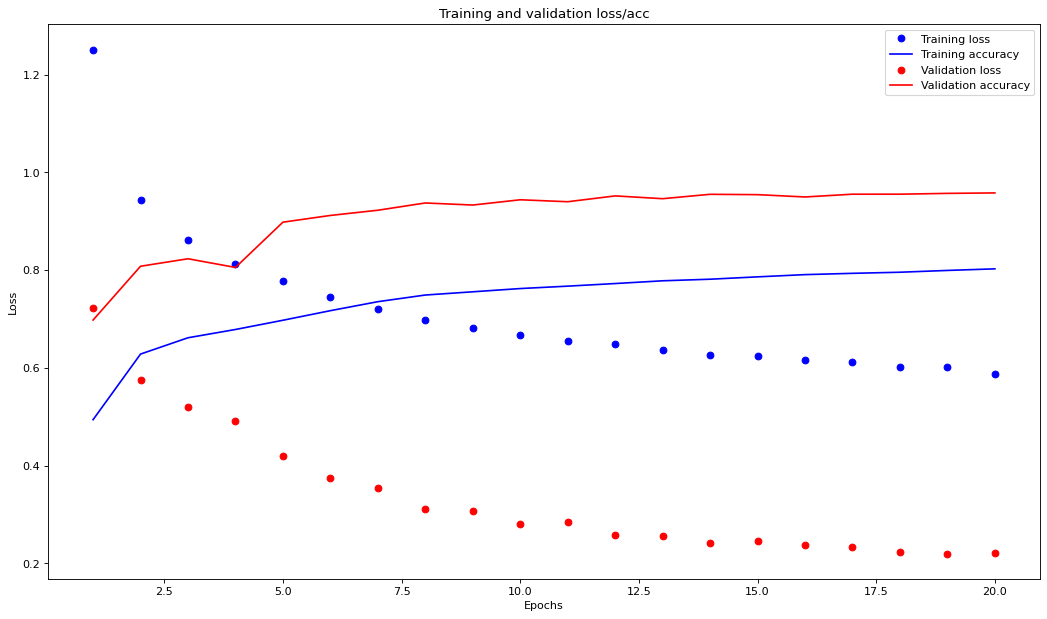

In [18]:
plot_history(history)

In [19]:
# save model 
model.save('deepfit_classifier_v3.h5')

In [20]:
# load model
# model = tf.keras.models.load_model('deepfit_classifier_v2.h5')

# Random Testing

1/1 [==============================] - 0s 105ms/step
Estimated pose:
squats: 	4.1064943e-18
lunges: 	0.0
bicep_curls: 	3.1681995e-24
situps: 	0.0
pushups: 	0.0
tricep_extensions: 	7.452701e-36
dumbbell_rows: 	2.0761928e-26
jumping_jacks: 	9.253678e-05
dumbbell_shoulder_press: 	0.009372128
lateral_shoulder_raises: 	0.9905353

Prediction: lateral_shoulder_raises
Actual Label :lateral_shoulder_raises


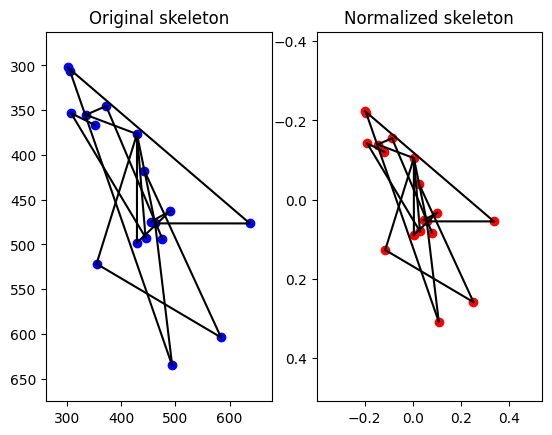

In [21]:
# Testing on single example
LABELS = list(d.keys())
ind = np.random.randint(0,70000)
X_sample = load_X('data/X_test.txt')[ind:2+ind]
X_sample_norm = norm_X(X_sample)
y_out = model.predict(X_sample_norm[0].reshape(1, 36))

print("Estimated pose:")
for idx in range(len(LABELS)):
    print(LABELS[idx] + ": \t" + str(y_out[0][idx]))
plot(X_sample[1])
print('\nPrediction: ',end='')
print(LABELS[np.argmax(y_out)])
print('Actual Label :', end='')
print(LABELS[int(load_Y('data/Y_test.txt')[ind])])

In [22]:
y_out.max()

0.9905353

# Evaluation on Held Out Data

In [23]:
model.evaluate(
    X_val_norm,
    Y_val,
    verbose=1
)

455/455 [==============================] - 1s 2ms/step - loss: 0.4174 - accuracy: 0.9385


[0.417354553937912, 0.9385271072387695]

# TF Lite Conversion

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
# Save the model.
with open('deepfit_classifier_v3.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\meetp\AppData\Local\Temp\tmpwox39k18\assets


In [25]:
# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='deepfit_classifier_v3.tflite')
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Setup input
X_sample = load_X('data/X_test.txt')[0+1234].reshape(1,-1)
X_sample_norm = norm_X(X_sample)

In [26]:
X_sample

array([[586.167, 586.247, 525.52 , 480.556, 554.919, 645.017, 686.225,
        621.596, 541.314, 494.274, 490.212, 623.514, 666.689, 656.837,
        572.501, 598.057, 556.825, 617.533, 186.653, 251.303, 245.461,
        337.549, 288.424, 255.161, 347.232, 288.383, 415.846, 525.507,
        668.598, 413.869, 521.653, 666.673, 174.888, 176.802, 180.777,
        180.831]], dtype=float32)

In [27]:
X_sample_norm.shape

(1, 36)

In [28]:
input_details

[{'name': 'serving_default_dense_input:0',
  'index': 0,
  'shape': array([ 1, 36]),
  'shape_signature': array([-1, 36]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [29]:
# Set up your input data.
input_data = np.array(X_sample_norm[0], np.float32).reshape(1,36)
input_data.shape

(1, 36)

In [30]:

# Invoke the model on the input data
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Get the result 
output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

[[8.8903821e-01 5.3998021e-05 2.3151662e-03 3.2084108e-06 1.1409413e-17
  6.8201773e-02 5.8928392e-05 2.5660319e-02 1.4614177e-02 5.4217682e-05]]


In [31]:
output_data[0].max()

0.8890382